***THE BATTLE OF NEIGHBORHOODS***

**Introduction**

There are many restaurants in New York City, belonging to different categories like Chinese, Indian, and French etc. The facts mentioned in the introduction make New York City to be an attractive market in terms of food business. Perspectives of opening Russian restaurant are considered in the present project.

**Data**

1) List of boroughs and neighbourhoods of New York City with their latitude and longitude

2) Russian restaurants in each neighbourhood of New York City

3) GeoSpace data

**Considered issues**

1) Visualization of all major parts of New York City that have reach Russian restaurants. 

2) What is best location for Russian Cuisine in New York City?

3) Which areas can be considered as a potential Russian restaurant market?

4) What is the best place to stay if you prefer Russian Cuisine?

**First step is importing libraties**

In [1]:
#! pip install lxml
#! pip install BeautifulSoup4

import numpy as np 
import pandas as pd
import requests
import lxml.html as lh
import bs4 as bs
import urllib.request
import json

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#!pip install geocoder
#!pip install folium
#!pip install geopy

import geocoder
import os

import folium # map rendering library

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Let me define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Next we define a function to interact with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [4]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '3API0X0UYMDORD5TTGCJOX3UVMO4BKA1PG1VGES00SCMQCAH' # your Foursquare ID
    CLIENT_SECRET = '3NNCVYMLFTS0AAANUU3ZW5DUGRRU4PEPROXFXZRK43WQRENT' # your Foursquare Secret
    VERSION = '20201020' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Next we will define a function to get venue details like count , rating , tip counts for a given venue id. This will be used for ranking.

In [29]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '3API0X0UYMDORD5TTGCJOX3UVMO4BKA1PG1VGES00SCMQCAH' # your Foursquare ID
    CLIENT_SECRET = '3NNCVYMLFTS0AAANUU3ZW5DUGRRU4PEPROXFXZRK43WQRENT' # your Foursquare Secret
    VERSION = '20201020' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Then we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

The funtion described above are called

In [7]:
new_york_data=get_new_york_data()

In [8]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
new_york_data.shape

(306, 4)

The above result shows that there are 306 different Neighborhoods in New York.
Now let create a BAR PLOT to show different Neighborhoods in New York.

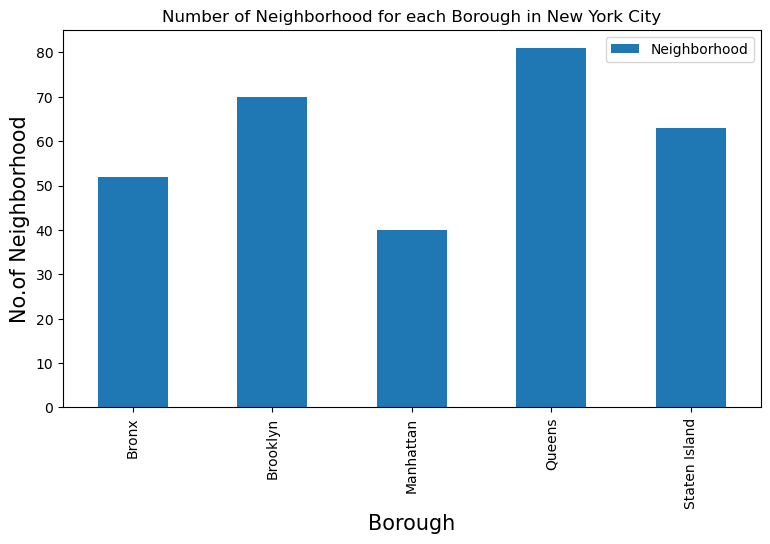

In [10]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

It is seen from the above Bar Plot that **Queens has highest number of neighborhoods**.

Next we  create a list of Russian resturants for each Neighborhood.

In [11]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
russian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    russian_resturants=venues[venues['Category']=='Russian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Russian Resturants in '+Neighborhood+', '+Borough+':'+str(len(russian_resturants)))
    for resturant_detail in russian_resturants.values.tolist():
        id, name , category=resturant_detail
        russian_rest_ny = russian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Russian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Russian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Russian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Russian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Russian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Russian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Russian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Russian Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Russian Resturants in Norwood, Bronx:0
( 10 / 306 ) Russian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Russian Resturants in Baychester, Bronx:0
( 12 / 306 ) Russian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Russian Resturants in City Island, Bronx:0
( 14 / 306 ) Russian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Russian Resturants in University Heights, Bronx:0
( 16 / 306 ) Russian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Russian Resturants in Fordham, Bronx:0
( 18 / 306 ) Russian Resturants in East Tremont, Bronx:

Now we have a list of all the Russian resturants in New York City! Let's study it.

In [12]:
russian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Gravesend,4a2937fcf964a52069951fe3,Stolovaya
1,Brooklyn,Brighton Beach,4ac69109f964a52017b520e3,Skovorodka
2,Brooklyn,Brighton Beach,4245f780f964a52070201fe3,Tatiana Restaurant
3,Brooklyn,Brighton Beach,4c1ea63763750f474c19ba67,Volna Café
4,Brooklyn,Sheepshead Bay,5a08f7e2d48ec1369706f57d,Bellarussian Xata


In [13]:
russian_rest_ny.shape

(21, 4)

***As you can see, there are 16 Russian Resturants in New York City.***

Next, a BAR PLOT is built to show number of Russian Resturants for each Borough in New York City.

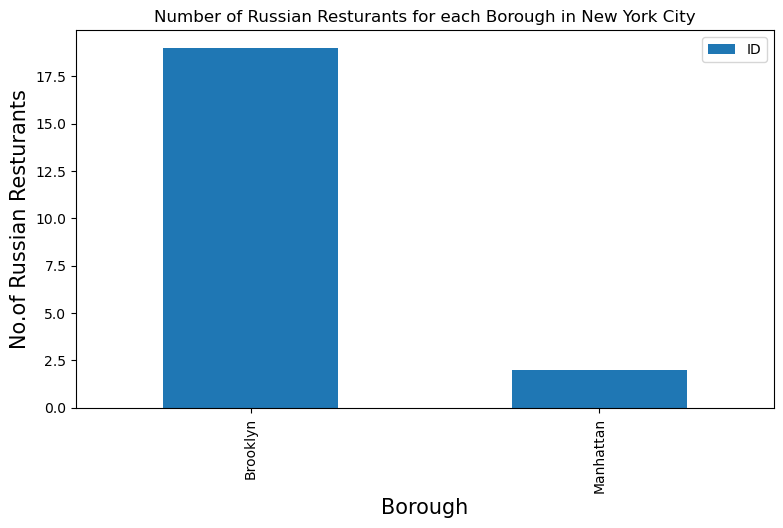

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Russian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Russian Resturants', fontsize=15)
#giving a bar plot
russian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

***As you can see from the above Bar Plot, most of the Russian restaurants in New York City are situated in Brooklyn***

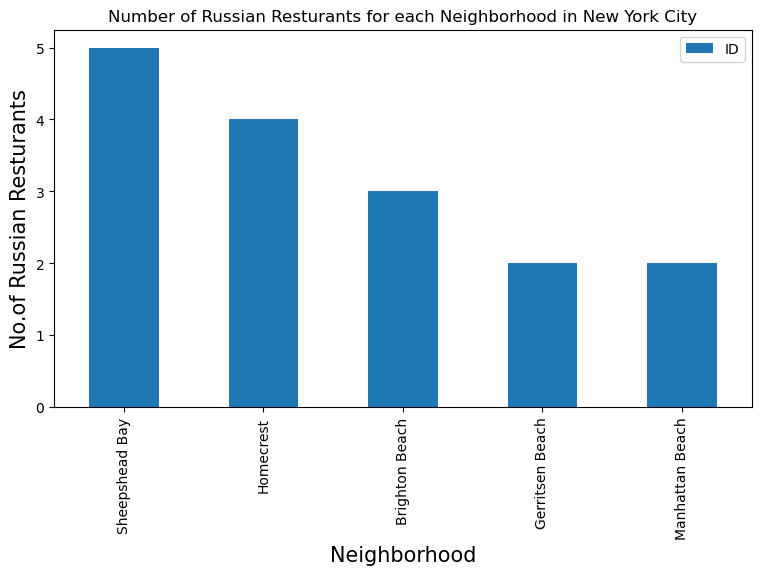

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Russian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Russian Resturants', fontsize=15)
#giving a bar plot
russian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [17]:
russian_rest_ny[russian_rest_ny['Neighborhood']=='Sheepshead Bay']

,Borough,Neighborhood,ID,Name
4,Brooklyn,Sheepshead Bay,5a08f7e2d48ec1369706f57d,Bellarussian Xata
5,Brooklyn,Sheepshead Bay,55d6885e498e41b9e7b8b5e8,Cafe Dushanbe
6,Brooklyn,Sheepshead Bay,5324ee02498e9a825bb4f689,La Vue Restaurant
7,Brooklyn,Sheepshead Bay,4b53cec1f964a520f9ab27e3,Vanka Vstanka
8,Brooklyn,Sheepshead Bay,4b2ecbf5f964a520cee624e3,Passage


***We can see that Sheepshead Bay in Brooklyn has the highest number of Russian Resturants with a total count of 5***

Now we will get the ranking of each resturant for further analysis

In [30]:
# prepare neighborhood list that contains Russian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
russian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in russian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(russian_rest_ny),')','processed')
    russian_rest_stats_ny = russian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID       Name  Likes  Rating  Tips
0  4a2937fcf964a52069951fe3  Stolovaya     40     8.0    27
( 1 / 21 ) processed
                         ID        Name  Likes  Rating  Tips
0  4ac69109f964a52017b520e3  Skovorodka     95     7.9    48
( 2 / 21 ) processed
                         ID                Name  Likes  Rating  Tips
0  4245f780f964a52070201fe3  Tatiana Restaurant    161     7.0    67
( 3 / 21 ) processed
                         ID        Name  Likes  Rating  Tips
0  4c1ea63763750f474c19ba67  Volna Café     34     6.0    21
( 4 / 21 ) processed
                         ID               Name  Likes  Rating  Tips
0  5a08f7e2d48ec1369706f57d  Bellarussian Xata     24     8.5     7
( 5 / 21 ) processed
                         ID           Name  Likes  Rating  Tips
0  55d6885e498e41b9e7b8b5e8  Cafe Dushanbe     13     7.3     4
( 6 / 21 ) processed
                         ID               Name  Likes  Rating  Tips
0  5324ee02498e9a825bb4f689  La Vue Rest

In [31]:
russian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Gravesend,4a2937fcf964a52069951fe3,Stolovaya,40,8.0,27
1,Brooklyn,Brighton Beach,4ac69109f964a52017b520e3,Skovorodka,95,7.9,48
2,Brooklyn,Brighton Beach,4245f780f964a52070201fe3,Tatiana Restaurant,161,7.0,67
3,Brooklyn,Brighton Beach,4c1ea63763750f474c19ba67,Volna Café,34,6.0,21
4,Brooklyn,Sheepshead Bay,5a08f7e2d48ec1369706f57d,Bellarussian Xata,24,8.5,7


In [32]:
russian_rest_stats_ny.shape

(21, 7)

In [33]:
russian_rest_ny.shape

(21, 4)

Now that we have data for all resturants. Then lets save this data to a csv-file. As the number of calls to get details for venue are premium call and have limit of 950 per day, we will refer to saved data sheet csv if required.

In [34]:
russian_rest_stats_ny.to_csv('russian_rest_stats_ny.csv', index=False)

Verification of the CVS-file:

In [35]:
russian_rest_stats_ny_csv=pd.read_csv('russian_rest_stats_ny.csv')

In [36]:
russian_rest_stats_ny_csv.shape

(21, 7)

In [37]:
russian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Gravesend,4a2937fcf964a52069951fe3,Stolovaya,40,8.0,27
1,Brooklyn,Brighton Beach,4ac69109f964a52017b520e3,Skovorodka,95,7.9,48
2,Brooklyn,Brighton Beach,4245f780f964a52070201fe3,Tatiana Restaurant,161,7.0,67
3,Brooklyn,Brighton Beach,4c1ea63763750f474c19ba67,Volna Café,34,6.0,21
4,Brooklyn,Sheepshead Bay,5a08f7e2d48ec1369706f57d,Bellarussian Xata,24,8.5,7


In [38]:
russian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       21 non-null     object 
 1   Neighborhood  21 non-null     object 
 2   ID            21 non-null     object 
 3   Name          21 non-null     object 
 4   Likes         21 non-null     object 
 5   Rating        21 non-null     float64
 6   Tips          21 non-null     object 
dtypes: float64(1), object(6)
memory usage: 1.3+ KB


The Data type of 'Likes' and 'Tips' are of type 'String'. we will convert them into type 'Float' for further analysis.

In [39]:
russian_rest_stats_ny['Likes']=russian_rest_stats_ny['Likes'].astype('float64')
russian_rest_stats_ny['Tips']=russian_rest_stats_ny['Tips'].astype('float64')

In [40]:
russian_rest_stats_ny.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       21 non-null     object 
 1   Neighborhood  21 non-null     object 
 2   ID            21 non-null     object 
 3   Name          21 non-null     object 
 4   Likes         21 non-null     float64
 5   Rating        21 non-null     float64
 6   Tips          21 non-null     float64
dtypes: float64(3), object(4)
memory usage: 1.3+ KB


Now we are able to find Russian restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

In [41]:
# Resturant with maximum Likes
russian_rest_stats_ny.iloc[russian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a777018f964a5207be41fe3
Name                          Mari Vanna
Likes                                548
Rating                               8.9
Tips                                 193
Name: 15, dtype: object

In [42]:
# Resturant with maximum Rating
russian_rest_stats_ny.iloc[russian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a777018f964a5207be41fe3
Name                          Mari Vanna
Likes                                548
Rating                               8.9
Tips                                 193
Name: 15, dtype: object

In [43]:
# Resturant with maximum Tips
russian_rest_stats_ny.iloc[russian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a777018f964a5207be41fe3
Name                          Mari Vanna
Likes                                548
Rating                               8.9
Tips                                 193
Name: 15, dtype: object

As you can see, the best Russian restaurant in New York City is **'Mari Vanna'**

Next lets visualize neighborhood with maximum average rating of resturants:

In [44]:
ny_neighborhood_stats=russian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [45]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
1,Flatiron,8.900000
3,Gramercy,8.900000
4,Gravesend,8.000000
7,Manhattan Terrace,7.600000
8,Ocean Parkway,7.600000
9,Sheepshead Bay,7.080000
5,Homecrest,6.975000
0,Brighton Beach,6.966667
6,Manhattan Beach,6.750000
2,Gerritsen Beach,6.700000


Above are the top neighborhoods with top average rating of Russian resturants.

Similarly we will find the average rating of Russian Resturants for each Borough.

In [46]:
ny_borough_stats=russian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [47]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.900000
0,Brooklyn,7.068421


Visualization:

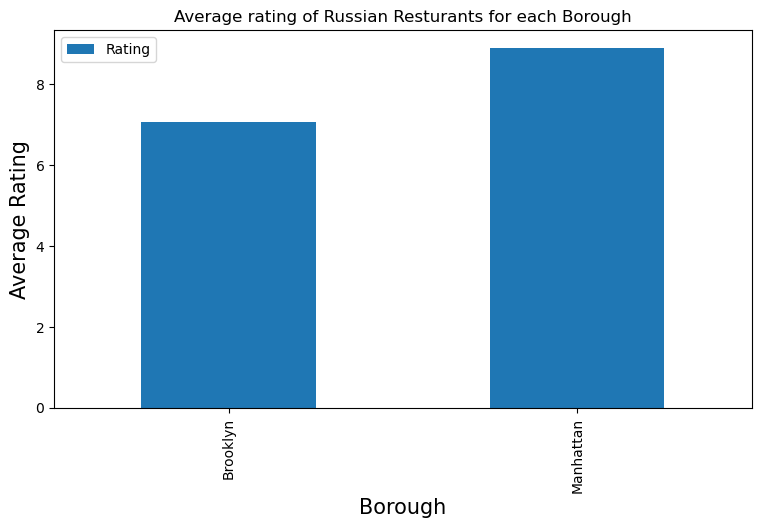

In [49]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Russian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
russian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

This statistics misleads us because there is only two Russian restaurants in Manhattan (see the corresponding  BAR-plot above).

Next we consider all the neighborhoods with average rating greater or equal 6.5 to visualize on map.

In [52]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.5]

In [53]:
ny_neighborhood_stats

,Neighborhood,Average Rating
1,Flatiron,8.9
3,Gramercy,8.9
4,Gravesend,8.0
7,Manhattan Terrace,7.6
8,Ocean Parkway,7.6


This dataset is combined into original New York data to get lonitude and latitude.

In [54]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [55]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [56]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Flatiron,40.739673,-73.990947,8.9
1,Manhattan,Gramercy,40.737210,-73.981376,8.9
2,Brooklyn,Gravesend,40.595260,-73.973471,8.0
3,Brooklyn,Manhattan Terrace,40.614433,-73.957438,7.6
4,Brooklyn,Ocean Parkway,40.613060,-73.968367,7.6


Finally, Let's show this data on a map.

In [57]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [58]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose.

In [59]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [60]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods. Lets Visualize Boroughs based on average rating.

In [71]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough_Boundaries.geojson'

map = ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

***Conclusion:***
Russian restaurants are especially frequent in Sheepshead Bay (Brooklyn), Homecrest (Brooklyn), and Brighton Beach (Brooklyn). For this reason the mentioned neighbourhoods are no so attractive for opening new Russian restaurant (here this market is filled). At the same time there are two Russian restaurant situated at Manhattan having the best rating. It is also not so easy to complete with them, especially at the beginning. Then the boroughts being open for opening new Russian restaurants are Bronx, Queens and Staten Island since the are no such restaurants there.

If you would like to try Russian cousine, the situation is inversed: Brooklyn and Manhattan are the best locations for you.